# Assignment 2 - Unsupervised Learning

Machine Learning (BBWL), Michael Mommert, FS2023, University of St. Gallen

The **goal** of this assignment is to perform clustering on **two separate datasets**: `blobs` contains a number of Gaussian clusters, wheres `moon` contains two crescent-shaped clusters that are intertwined. Both datasets are two-dimensional and contain different numbers of samples.

Your **objectives** are the following:
* Visualize both datasets.
* Implement at least one clustering method to identify clusters in the `blobs` dataset; how many different clusters are there in the dataset?
* Implement at least one clustering method that separates the vast majority of samples from the two crescent-shaped clusters in the `moons` dataset.
* For each dataset, visualize the resulting clusters by plotting samples belonging to different clusters in different clusters.

This assignment will be **graded** based on:
* whether these objectives have been achieved;
* whether the solution follows best practices;
* how well the approach is documented (e.g., using text cells, plots, etc.);
* how clean the code is.

There are no restrictions on the resources that you can use -- collaborating on assignments is allowed -- but students are not allowed to submit identical code.

Please submit your runnable Notebook to [michael.mommert@unisg.ch](mailto:michael.mommert@unisg.ch) **before 16 April 2023, 23:59**. Please include your name in the Notebook filename.

-----

The following code cell will import the dataset used in this assignment. Please do not modify this code cell.

In [2]:
import numpy as np
from urllib.request import urlopen
from io import BytesIO

# load data as binary npy file
blobs = np.load(BytesIO(urlopen("https://raw.githubusercontent.com/HSG-AIML-Teaching/MLBBWL-2023FS/main/assignment_2/blobs.npy").read()))
moons = np.load(BytesIO(urlopen("https://raw.githubusercontent.com/HSG-AIML-Teaching/MLBBWL-2023FS/main/assignment_2/moons.npy").read()))

Setup Environment

In [42]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

# import sklearn for kmeans, dbscan, silhouette score and standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# import scipy for distance calculation
from scipy.spatial.distance import cdist

# import seaborn for plotting
import seaborn as sns

# disable warnings
import warnings
warnings.filterwarnings("ignore")

----

# Dataset visualization

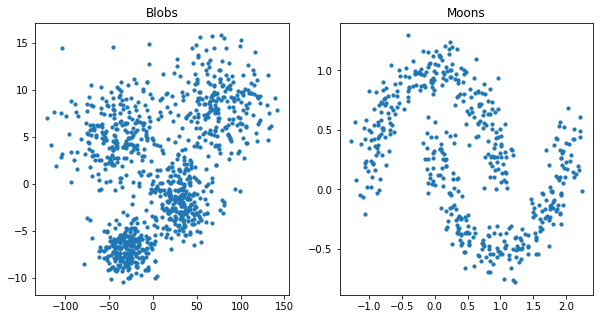

In [4]:
# plot blobs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(blobs[:, 0], blobs[:, 1], s=10)
plt.title("Blobs")

# plot moons
plt.subplot(1, 2, 2)
plt.scatter(moons[:, 0], moons[:, 1], s=10)
plt.title("Moons")
plt.show()

----

# Clustering on `blobs`

### 1. Scaling Data

In [5]:
# scale data
scaler = StandardScaler()
blobs_scaled = scaler.fit_transform(blobs)

----
### 2. Finding Clusters
#### 2.1 Elbow Method

The Elbow method is a technique for estimating the optimal number of clusters in a dataset. It involves plotting the explained variation (inertia) against the number of clusters and identifying the "elbow point" in the curve, which usually represents the optimal number of clusters. The elbow point is where the reduction in inertia starts decreasing at a slower rate, indicating that adding more clusters will not improve the model significantly. This method provides a visual way to determine the appropriate number of clusters but may not always be perfect, and sometimes other evaluation techniques or domain knowledge are necessary.

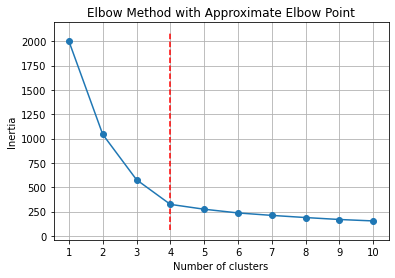

In [6]:
# Set the maximum number of clusters to try
max_clusters = 10
inertias = []

# Iterate through the range of cluster numbers and fit K-means
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(blobs_scaled)
    inertias.append(kmeans.inertia_)

# Calculate the distances of the inertia points from the line connecting the first and last points
x = np.arange(1, max_clusters + 1)
y = np.array(inertias)

# Calculate the line coefficients (a, b, c) for the line connecting the first and last points: ax + by + c = 0
a = y[-1] - y[0]
b = x[0] - x[-1]
c = x[-1] * y[0] - x[0] * y[-1]

# Calculate the distance of each point from the line
distances = np.abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)

# Find the index with the maximum distance
optimal_k_idx = np.argmax(distances)
optimal_k = x[optimal_k_idx]

# Plot the Elbow curve with the detected elbow point
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method with Approximate Elbow Point')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

#### 2.2 Silhouette Method
The silhouette method is an approach to evaluate the quality of clustering results by measuring the similarity between data points within the same cluster and their dissimilarity to data points in other clusters. The silhouette score is a metric that quantifies this evaluation and ranges from -1 to 1. A higher silhouette score indicates that the data points within the same cluster are more similar to each other and dissimilar to data points in other clusters, signifying a better clustering performance.

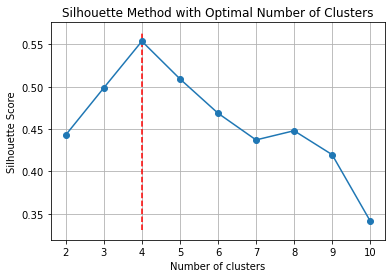

In [7]:
# Set the maximum number of clusters to try
max_clusters = 10
silhouette_scores = []

# Iterate through the range of cluster numbers and fit K-means
for k in range(2, max_clusters + 1):  # Start from 2 clusters since silhouette_score is not defined for 1 cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(blobs_scaled)
    labels = kmeans.labels_
    silhouette = silhouette_score(blobs_scaled, labels)
    silhouette_scores.append(silhouette)

# Find the index with the maximum silhouette score
optimal_k_idx = np.argmax(silhouette_scores)
optimal_k = optimal_k_idx + 2  # Add 2 to the index since the range starts from 2

# Plot the Silhouette curve with the detected optimal number of clusters
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method with Optimal Number of Clusters')
plt.xticks(range(2, max_clusters + 1))
plt.grid()
plt.show()

#### 2.3 Conclusion / Final CLustering
We applied the Elbow and Silhouette methods to determine the optimal number of clusters for our dataset. Both methods consistently identified 4 clusters as the best choice, increasing our confidence in this conclusion and suggesting that 4 clusters best represent the underlying structure of the data. Having established that 4 clusters is the optimal choice using both the Elbow and Silhouette methods, we can now apply clustering to the dataset with this configuration and visually examine the resulting clusters to reinforce the validity of our chosen clustering approach.

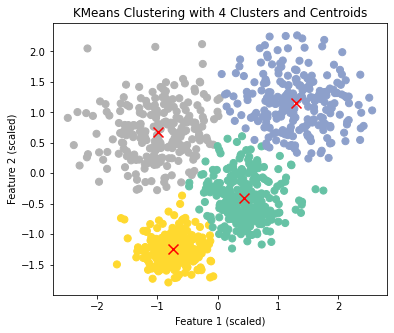

In [41]:
# Apply KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(blobs_scaled)

# Get cluster assignments for each data point and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Set up the figure
plt.figure(figsize=(6, 5))

# Visualize the clusters and centroids
plt.scatter(blobs_scaled[:, 0], blobs_scaled[:, 1], c=labels, cmap='Set2', marker='o', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.title('KMeans Clustering with 4 Clusters and Centroids')
plt.show()

#### 2.4 Some extra stuff just for fun
Just to make sure we can plot the results with cluster count 5 & 6 aswell.

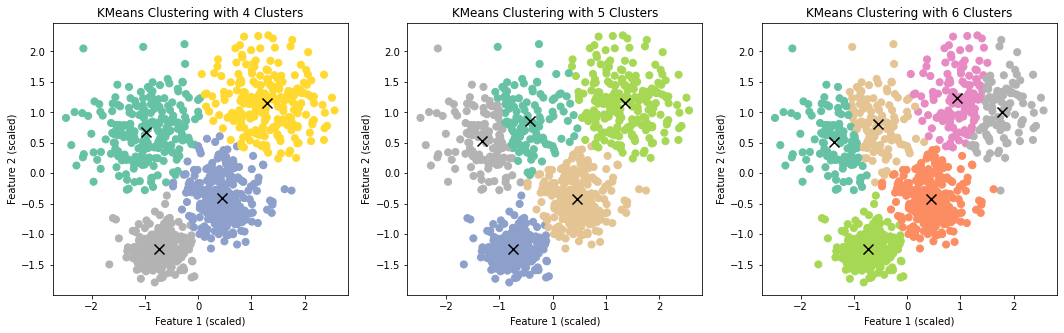

In [44]:
# Function to apply KMeans clustering and plot the results
def plot_kmeans_clusters(n_clusters, plot_id):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(blobs_scaled)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    plt.subplot(1, 3, plot_id)
    plt.scatter(blobs_scaled[:, 0], blobs_scaled[:, 1], c=labels, cmap='Set2', marker='o', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
    plt.xlabel('Feature 1 (scaled)')
    plt.ylabel('Feature 2 (scaled)')
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')

# Set up the figure
plt.figure(figsize=(18, 5))

# Plot the clustering results for 4, 5, and 6 clusters
plot_kmeans_clusters(4, 1)
plot_kmeans_clusters(5, 2)
plot_kmeans_clusters(6, 3)

# Display the plots
plt.show()

If we then draw circles around a defined amount of points around each centroid (95%) and mark the overlaps / not touched points we can really see a huge difference.

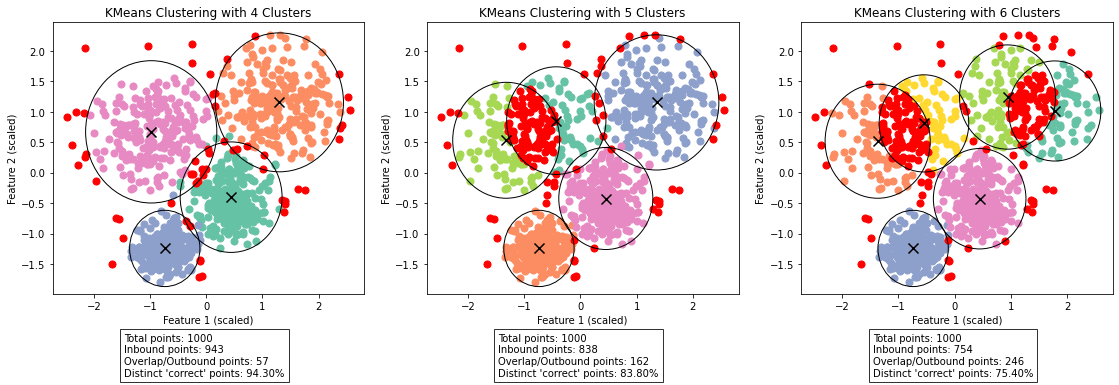

In [74]:
# Function to apply KMeans clustering and plot the results
def plot_kmeans_clusters(n_clusters, plot_id):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(blobs_scaled)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    plt.subplot(1, 3, plot_id)

    circle_membership_count = np.zeros(blobs_scaled.shape[0], dtype=int)
    
    for cluster_idx in range(n_clusters):
        cluster_points = blobs_scaled[labels == cluster_idx]
        centroid = centroids[cluster_idx]
        distances = cdist(blobs_scaled, centroid.reshape(1, -1)).flatten()
        radius = np.percentile(distances[labels == cluster_idx], 95)
        circle = plt.Circle(centroid, radius, edgecolor='black', fill=False)
        plt.gca().add_artist(circle)

        in_circle = distances <= radius
        circle_membership_count[in_circle] += 1

    for cluster_idx in range(n_clusters):
        in_circle = circle_membership_count == 1
        in_cluster_and_circle = np.logical_and(labels == cluster_idx, in_circle)
        plt.scatter(blobs_scaled[in_cluster_and_circle, 0], blobs_scaled[in_cluster_and_circle, 1], color=plt.cm.Set2.colors[cluster_idx], marker='o', s=50)
    
    points_to_color_red = circle_membership_count != 1
    plt.scatter(blobs_scaled[points_to_color_red, 0], blobs_scaled[points_to_color_red, 1], color='red', marker='o', s=50)

    plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
    
    plt.xlabel('Feature 1 (scaled)')
    plt.ylabel('Feature 2 (scaled)')
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    
    total_points = len(blobs_scaled)
    inbound_points = np.sum(circle_membership_count == 1)
    overlap_excluded_points = np.sum(circle_membership_count != 1)
    correct_points_percentage = (inbound_points / total_points) * 100
    
    plt.annotate(
        f"Total points: {total_points}\nInbound points: {inbound_points}\nOverlap/Outbound points: {overlap_excluded_points}\nDistinct 'correct' points: {correct_points_percentage:.2f}%",
        xy=(0.23, -0.3),
        xycoords='axes fraction',
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
    )

# Set up the figure
plt.figure(figsize=(19, 5))

# Plot the clustering results for 4, 5, and 6 clusters
plot_kmeans_clusters(4, 1)
plot_kmeans_clusters(5, 2)
plot_kmeans_clusters(6, 3)

# Display the plots
plt.show()

----
# Clustering on `moons`

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'moons', convert it to a NumPy array
data = moons

# Standardize the data for better performance
data = StandardScaler().fit_transform(data)

# Define the hyperparameter search space
eps_space = np.arange(0.1, 1.0, 0.0001)
min_samples_space = 2

# Variables to store the best hyperparameters and their Calinski-Harabasz Score
best_params = None
best_score = -1

# Grid search loop
for eps in eps_space:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    
    # Skip if only one cluster or all points are noise
    if len(np.unique(labels)) <= 1 or -1 not in np.unique(labels):
        continue
    
    score = calinski_harabasz_score(data, labels)
    
    if score > best_score:
        best_score = score
        best_params = {'eps': eps, 'min_samples': min_samples}

print("Best hyperparameters:", best_params)

# Apply DBSCAN with the best hyperparameters
best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels = best_dbscan.fit_predict(data)

# Plot the results
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering with Best Hyperparameters')
plt.show()

NameError: name 'min_samples' is not defined

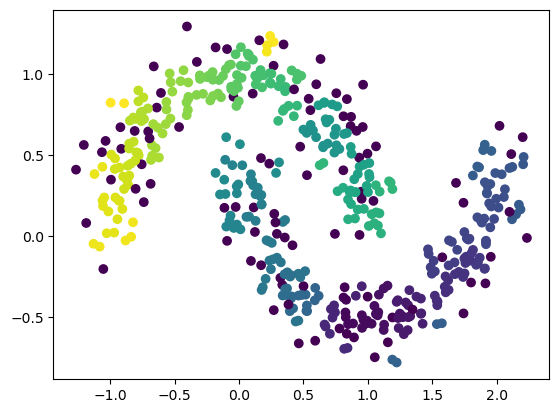

In [ ]:
# cluster moons data with optics
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=2).fit(moons)
moons_df["cluster"] = optics.labels_

# plot clustered data
plt.scatter(moons_df.x, moons_df.y, c=moons_df.cluster)
plt.show()